In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries
 
from textblob import TextBlob
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import string
import seaborn as sns
 
import nltk
nltk.downloader.download('vader_lexicon')
 
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
# load dataset and create dataframe
tweets_info = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/combinedTweetIDs.csv")

<ipython-input-3-d32b81afe0c4>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_info = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/combinedTweetIDs.csv")


In [4]:
# print(tweets_info.head())
print(tweets_info.shape)
print(tweets_info.columns)


# keep only the relevant column names
tweets_info = tweets_info.loc[:, ['lang', 'text', 'user_location']]

print("shape of tweets_info after only keeping relevant columns")
print("\n")
print(tweets_info.shape)
print(tweets_info.head())



(63056, 35)
Index(['coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'lang', 'place',
       'possibly_sensitive', 'quote_id', 'retweet_count', 'retweet_id',
       'retweet_screen_name', 'source', 'text', 'tweet_url', 'user_created_at',
       'user_id', 'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified'],
      dtype='object')
shape of tweets_info after only keeping relevant columns


(63056, 3)
  lang                                               text  \
0   en  Monkey pox seems to have moved from a infectio...   
1   en  14 days to slow the spread and prepare the hos...   
2   en  @Morcia @SkyNews Monkey pox isn't hitting the ...   
3 

In [5]:
# dropping duplicates

print("before dropping duplicates")
print(tweets_info.shape)
tweets_info.drop_duplicates(inplace=True)
print("after dropping duplicates")
print(tweets_info.shape)


before dropping duplicates
(63056, 3)
after dropping duplicates
(62743, 3)


In [6]:
# dropping languages other than English 

print(tweets_info['lang'].unique()) 

tweets_info = tweets_info[tweets_info['lang'] == 'en']

print("\n tweets_info shape after dropping other languages: ")
print(tweets_info.shape)


['en' 'fr' 'es' 'pt' 'fi' 'de' 'sv' 'tr' 'ja' 'qme' 'pl' 'nl' 'in' 'und'
 'zxx' 'hi' 'ta' 'it' 'qht' 'tl' 'ht' 'sl' 'da' 'ur' 'ro' 'cy' 'lv' 'th'
 'qst' 'bn' 'is' 'et' 'art' 'te' 'el' 'iw' 'lt' 'ca' 'hu' 'qam' 'ko' 'ml'
 'fa' 'am' 'no' 'zh' 'ne' 'ar' 'ru' 'gu' 'kn' 'mr' 'ps' 'cs' 'eu' 'vi'
 'pa' 'uk' 'sr']

 tweets_info shape after dropping other languages: 
(58106, 3)


In [7]:
tweets_info.isnull().sum()

lang                 0
text                 0
user_location    20548
dtype: int64

In [8]:
# more EDA
pd.options.display.max_colwidth = 1300
print(tweets_info.iloc[1:10, 1])




1                                                                                                                                                                                14 days to slow the spread and prepare the hospitals Jesse. Don’t kill grandma bigot. https://t.co/QeKGjCBQqt
2                                                                                                                                                                                                  @Morcia @SkyNews Monkey pox isn't hitting the ground running as they were expecting either.
3                                                                                                                                      Addern back making a fucking idiot of herself.\n\nLook how desperate she becomes when no one wants to talk about her MonkeyPox. https://t.co/cMUyOUoF5b
5                   @DamienSReynolds @oolon @TNLComFund As you only mention LGB people ill go with bad faith. But also worth remembering th

In [9]:
# Removing RT, Punctuation etc
def remove_rt(x): return re.sub('RT @\w+: ', " ", x)
 
def rt(x): return re.sub(
    "(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x)
 
tweets_info["text"] = tweets_info.text.map(remove_rt).map(rt)
tweets_info["text"] = tweets_info.text.str.lower()

# reset dataframe row index
tweets_info = tweets_info.reset_index(drop=True)

pd.options.display.max_colwidth = 1300
print(tweets_info.iloc[0:10, 1])

0                                                                                                                                                     monkey pox seems to have moved from a infection caused by anal sex to an airborne desease in a week  this is desperation   
1                                                                                                                                                                                         14 days to slow the spread and prepare the hospitals jesse  don t kill grandma bigot   
2                                                                                                                                                                                                      monkey pox isn t hitting the ground running as they were expecting either 
3                                                                                                                                                 addern back making a fucking idi

In [10]:
tweets_info[['polarity', 'subjectivity']] = tweets_info['text'].apply(
    lambda Text: pd.Series(TextBlob(Text).sentiment))

In [11]:
for index, row in tweets_info['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
     
    if neg > pos:
        tweets_info.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tweets_info.loc[index, 'sentiment'] = "positive"
    else:
        tweets_info.loc[index, 'sentiment'] = "neutral"
         
    tweets_info.loc[index, 'neg'] = neg
    tweets_info.loc[index, 'neu'] = neu
    tweets_info.loc[index, 'pos'] = pos
    tweets_info.loc[index, 'compound'] = comp

In [12]:
tweets_info[["text", "sentiment", "polarity",
        "subjectivity", "neg", "neu", "pos"]].head(5)

,text,sentiment,polarity,subjectivity,neg,neu,pos
0,monkey pox seems to have moved from a infection caused by anal sex to an airborne desease in a week this is desperation,negative,-0.050000,0.000000,0.130,0.870,0.000
1,14 days to slow the spread and prepare the hospitals jesse don t kill grandma bigot,negative,-0.300000,0.400000,0.251,0.749,0.000
2,monkey pox isn t hitting the ground running as they were expecting either,neutral,-0.050000,0.000000,0.000,1.000,0.000
3,addern back making a fucking idiot of herself look how desperate she becomes when no one wants to talk about her monkeypox,negative,-0.300000,0.475000,0.310,0.690,0.000
4,as you only mention lgb people ill go with bad faith but also worth remembering that only days ago they called for the shutting of mens saunas etc to stop the spread of monkey pox so not just the t community they disapprove of,negative,-0.158333,0.627778,0.141,0.772,0.086


In [13]:
total_pos = len(tweets_info.loc[tweets_info['sentiment'] == "positive"])
total_neg = len(tweets_info.loc[tweets_info['sentiment'] == "negative"])
total_neu = len(tweets_info.loc[tweets_info['sentiment'] == "neutral"])
total_tweets = len(tweets_info)
print("Total Positive Tweets % : {:.2f}"
      .format((total_pos/total_tweets)*100))
print("Total Negative Tweets % : {:.2f}"
      .format((total_neg/total_tweets)*100))
print("Total Neutral Tweets % : {:.2f}"
      .format((total_neu/total_tweets)*100))



Total Positive Tweets % : 29.80
Total Negative Tweets % : 33.99
Total Neutral Tweets % : 36.21


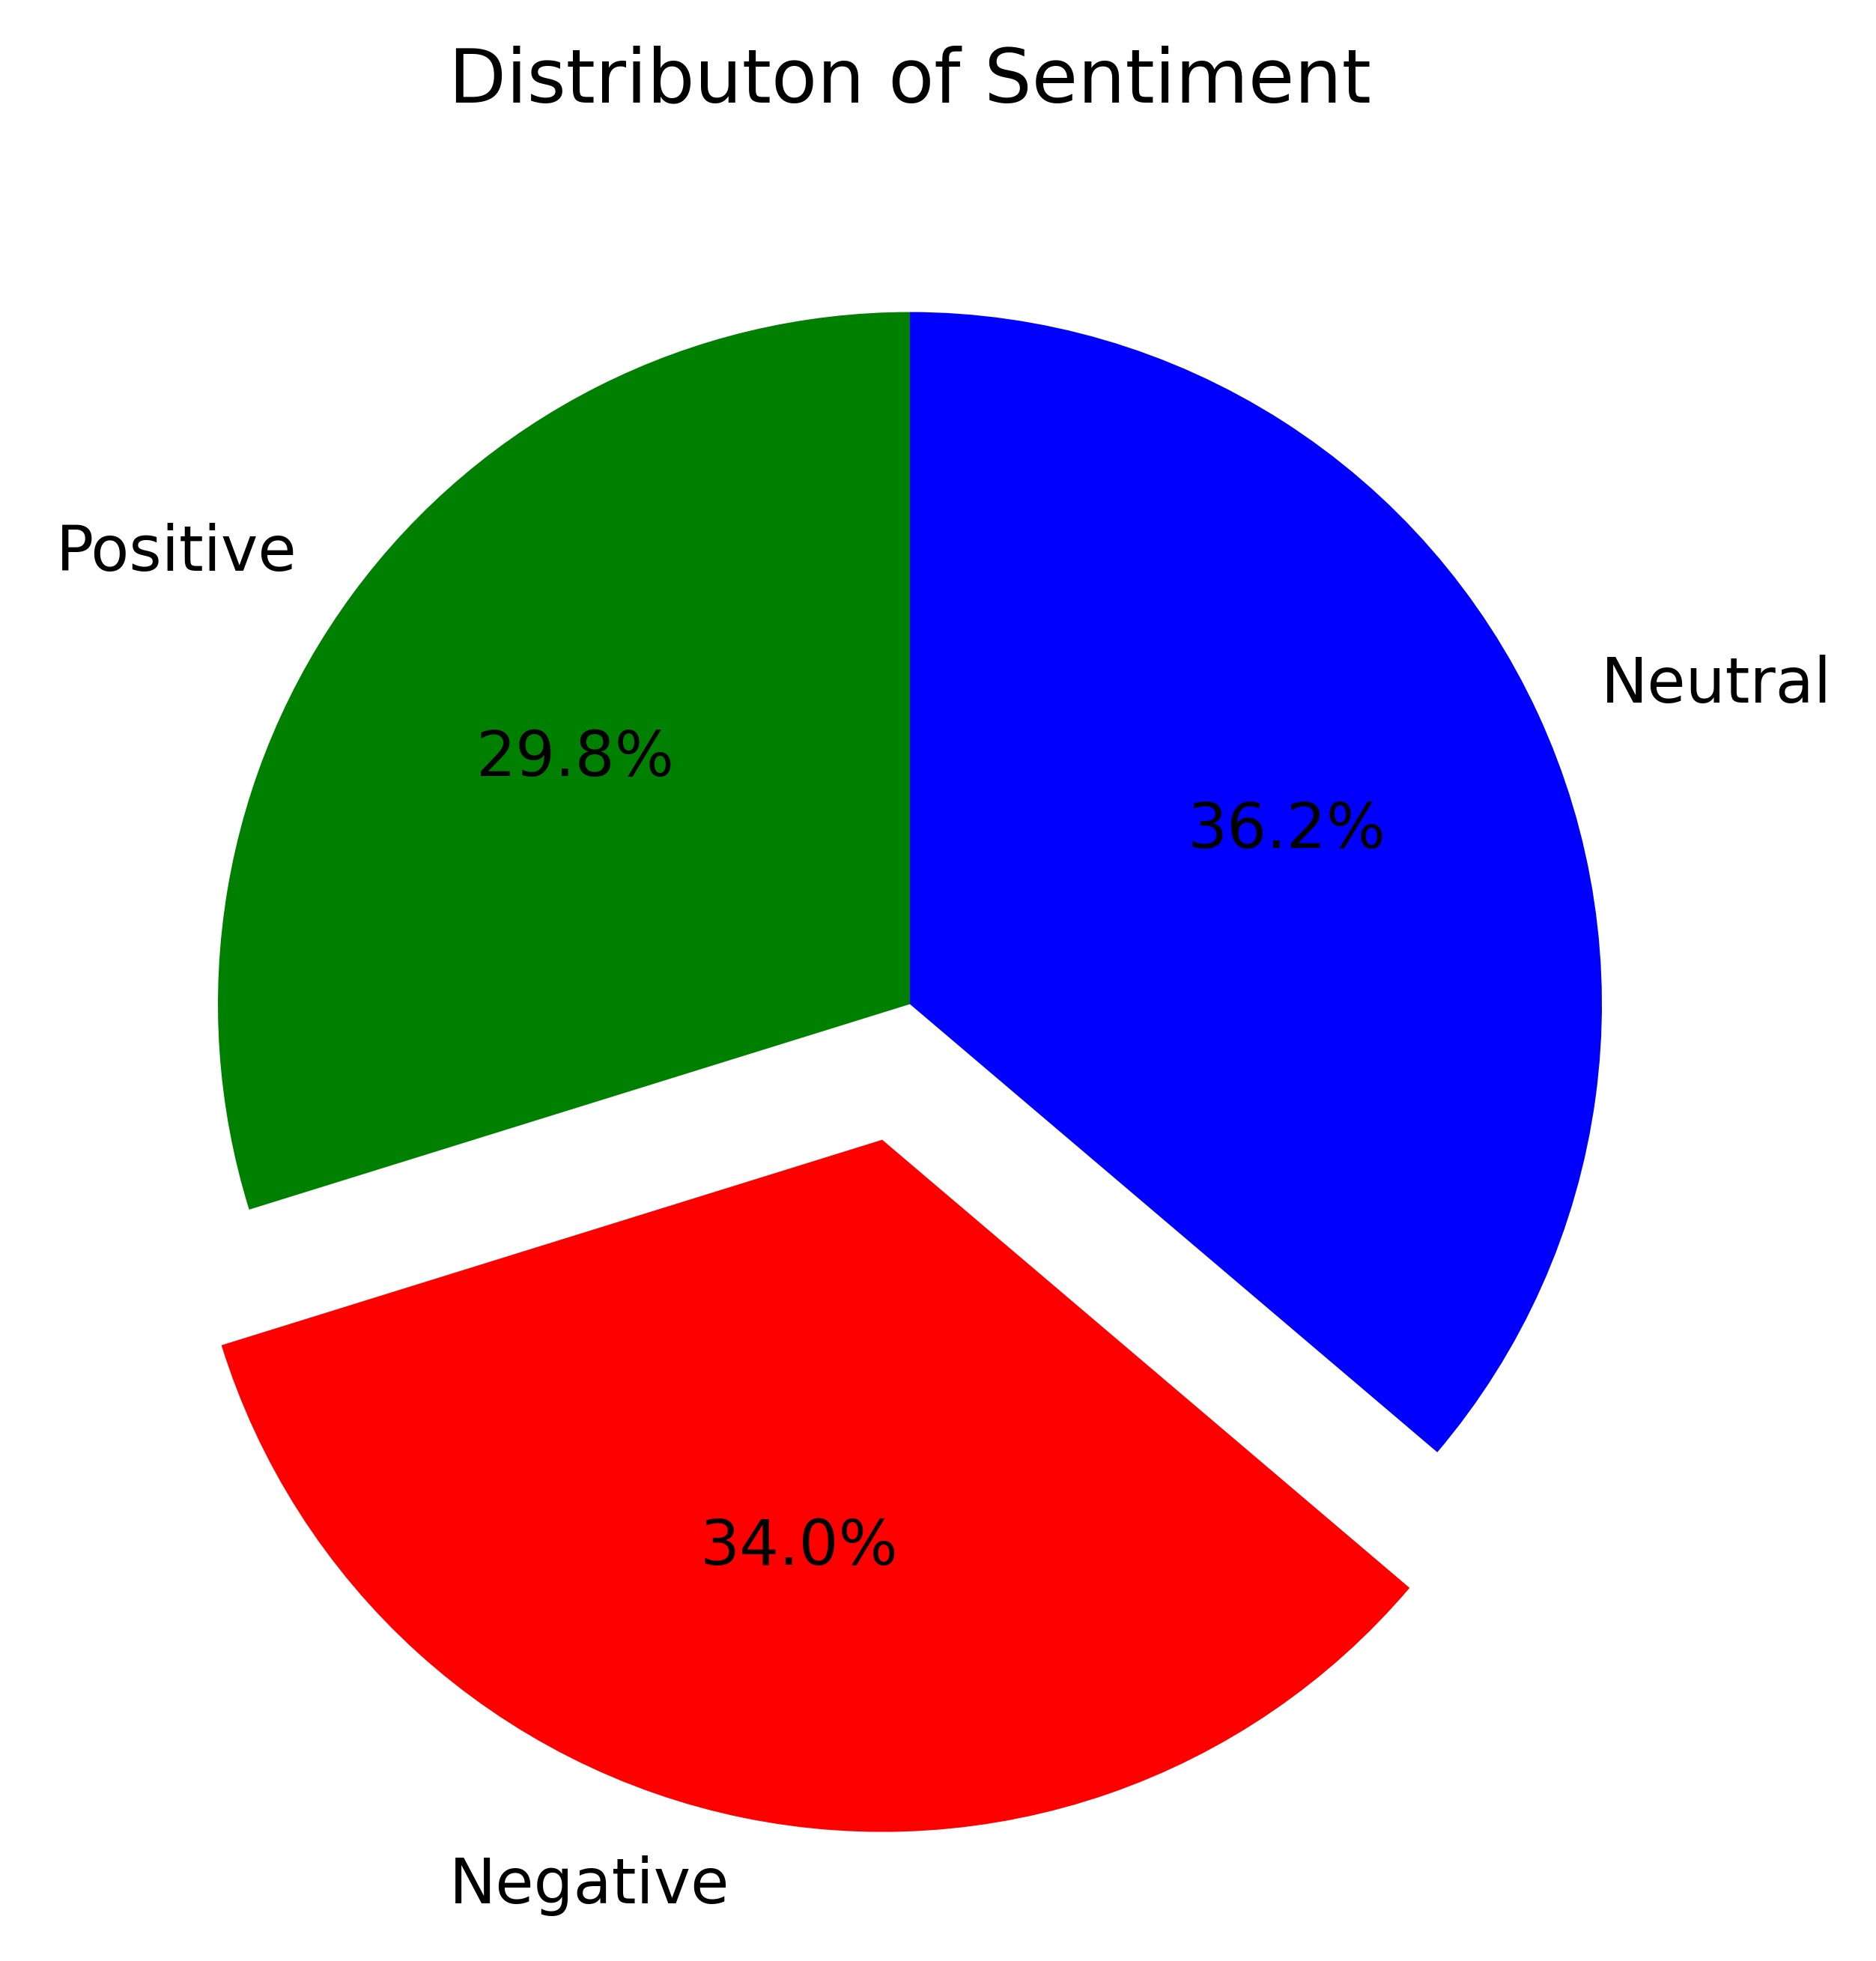

In [14]:
# Pie Chart showing percentage of each sentiment

mylabels = ["Positive", "Negative", "Neutral"]
mycolors = ["Green", "Red", "Blue"]
 
plt.figure(figsize=(8, 5),
           dpi=600)  # Push new figure on stack
myexplode = [0, 0.2, 0]
plt.pie([total_pos, total_neg, total_neu], colors=mycolors,
        labels=mylabels, explode=myexplode, autopct='%1.1f%%', startangle = 90)

plt.title('Distributon of Sentiment')
plt.show()



In [15]:
#Function to Create Wordcloud
def create_wordcloud(text):
 mask = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/cloud.png"))
 stopwords = set(STOPWORDS)
 wc = WordCloud(background_color="white", mask = mask, max_words=3000, stopwords=stopwords, repeat=True)
 wc.generate(str(text))
 wc.to_file("wc.png")
 print("Word Cloud Saved Successfully")
 path="wc.png"
 display(Image.open(path))

In [16]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tweets_info[tweets_info["sentiment"]=="negative"]
tw_list_positive = tweets_info[tweets_info["sentiment"]=="positive"]
tw_list_neutral = tweets_info[tweets_info["sentiment"]=="neutral"]

Word Cloud Saved Successfully


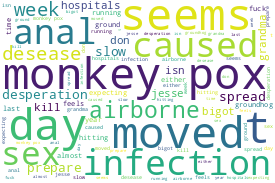

In [17]:
#Creating wordcloud for all tweets
create_wordcloud(tweets_info["text"].values)

Word Cloud Saved Successfully


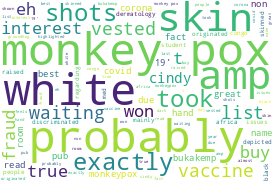

In [18]:
#Creating wordcloud for positive sentiment
create_wordcloud(tw_list_positive["text"].values)

Word Cloud Saved Successfully


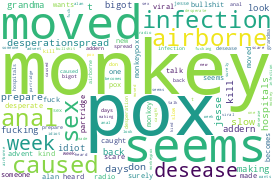

In [19]:
#Creating wordcloud for negative sentiment
create_wordcloud(tw_list_negative["text"].values)

Word Cloud Saved Successfully


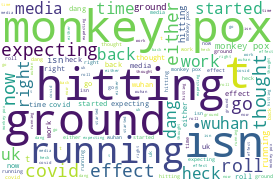

In [20]:
#Creating wordcloud for neutral sentiment
create_wordcloud(tw_list_neutral["text"].values)